

## Preprocesamiento de datos multivariados o de una serie temporal

## 1. Cargar dataset

In [3]:
%cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content


In [4]:
!pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.8 MB 37.6 MB/s 
     |████████████████████████████████| 9.8 MB 53.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from tbats import TBATS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Visualizar el dataset

In [6]:
data = pd.read_csv('Alcohol_Sales.csv')
data.columns = ['date', 'sales']
data['date'] = data['date'].astype('str')
data

,date,sales
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


## 2. Probar estacionalidad

Ya que se trata de una serie de tiempo, la separación de los datos de entrenamiento y de pruebas no puede tener el parámetro shuffle=True, ya que esto podría afectar las predicciones porque para estas sí es importante el orden de los resultados y de los inputs

In [8]:
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)

Haciendo uso de matplotlib generaremos una gráfica para ver si los datos son estacionarios o no. Para poder visualizar mejor los datos, se visualizarán con un intervalo de 10.

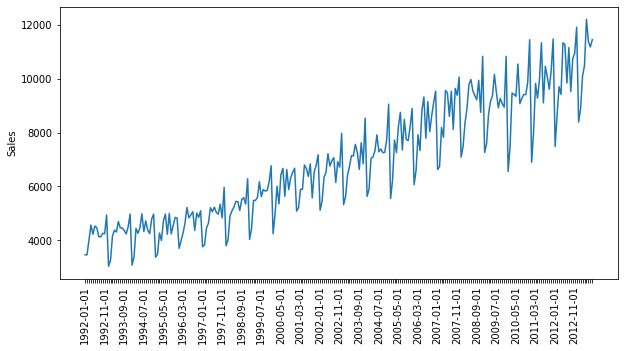

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(data_train['date'], data_train['sales'])
plt.xticks(rotation = 90,size=10)
plt.ylabel('Sales')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

Podemos observar que existe un trend en los datos, por lo que afirmaremos que se trata de una serie de datos no estacionaria, pero aún así, para estar completamente seguros haremos las pruebas de Dickey-Fuller y KPSS.



In [10]:
def test_stationary(timeseries):

	rolmean = timeseries.rolling(window=12).mean()
	rolstd = timeseries.rolling(window=12).std()
	
	orig = plt.plot(timeseries, color='blue', label='Original')
	mean = plt.plot(rolmean, color='red', label='Rolling Mean')
	st = plt.plot(rolstd, color='black', label='Rolling Std')
	plt.legend(loc='best')
	plt.title('Rolling Mean & Standard Deviation')
	plt.show()

	#Dickey-Fuller:
	print('Results of Dickey-Fuller Test:')
	dftest = adfuller(timeseries)
	dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
	for key, value in dftest[4].items():
		dfoutput['Critical Value(%s)' %key] = value
	print(dfoutput)

	#KPSS:
	print('Results of KPSS Test:')
	kpsstest = kpss(timeseries, regression='c')
	kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
	for key, value in kpsstest[3].items():
		kpss_output['Critical Value (%s)' %key] = value
	print(kpss_output)

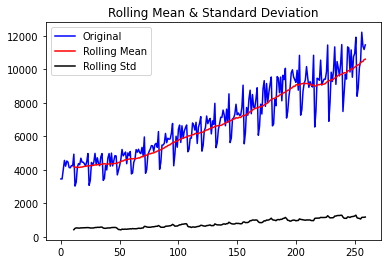

Results of Dickey-Fuller Test:
Test Statistic                   1.534774
p-value                          0.997648
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value(1%)              -3.457326
Critical Value(5%)              -2.873410
Critical Value(10%)             -2.573096
dtype: float64
Results of KPSS Test:
Test Statistic            2.468021
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [11]:
test_stationary(data_train['sales'])

Podemos observar que la prueba Dickey-Fuller nos dió un valor de 0.997 y la prueba KPSS nos dió un valor de 0.01.

Ya que nuestra p de Dickey-Fuller es mayor a 0.05 y nuestra p de KPSS es menor a 0.05, podemos concluir con certeza que nuestra serie de tiempo no es estacionaria.

## Diferenciar la serie de tiempo

Ya que para entrenar nuestro modelo nos interesa tener una serie de tiempo estacionaria, diferenciaremos la serie para quitar el trend y volver estacionaria nuestra serie

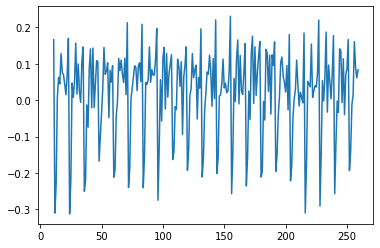

In [12]:
tslog = np.log(data_train['sales'])
rollavg = tslog.rolling(12).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

Podemos observar que el trend se redujo significativamente y ahora nuestra serie de tiempo se ve estacionaria, pero de nuevo, para estar seguros haremos las pruebas de Dickey-Fuller y KPSS.

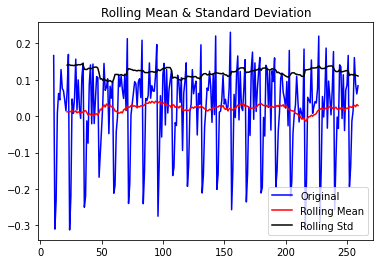

Results of Dickey-Fuller Test:
Test Statistic                  -3.531175
p-value                          0.007222
#Lags Used                      14.000000
Number of Observations Used    234.000000
Critical Value(1%)              -3.458608
Critical Value(5%)              -2.873972
Critical Value(10%)             -2.573396
dtype: float64
Results of KPSS Test:
Test Statistic           0.039888
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [13]:
test_stationary(tslogdiff)

Podemos observar que la prueba Dickey-Fuller nos dió un valor de 0.007 y la prueba KPSS nos dió un valor de 0.1

Ya que nuestra p de Dickey-Fuller es menor a 0.05 y nuestra p de KPSS es mayor a 0.05, podemos concluir con certeza que nuestra serie de tiempo no es estacionaria.

## Autocorrelación(ACF) y autocorrelación parcial(PACF)

Para poder analizar el ACF y PACF de nuestra serie de tiempo, necesitaremos diferenciarla otra vez. Para esto usaremos la siguiente función:

$r_t=log(\frac{X_t}{X_{t-1}})$

Esta función estabiliza la serie haciendo uso del logaritmo y la diferencia usando t-1

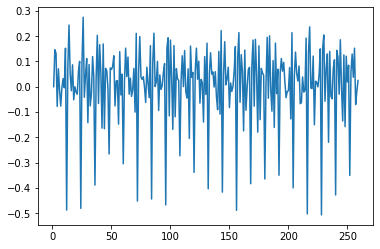

In [14]:
tslog = np.log(data_train['sales'])
logret= diff(tslog)
plt.plot(logret)
plt.show()

Ya que diferenciamos por segunda vez nuestra serie, estamos listos para generar las gráficas del ACF y PACF y así visualizar la autocorrelación de nuestras variables.

---



/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


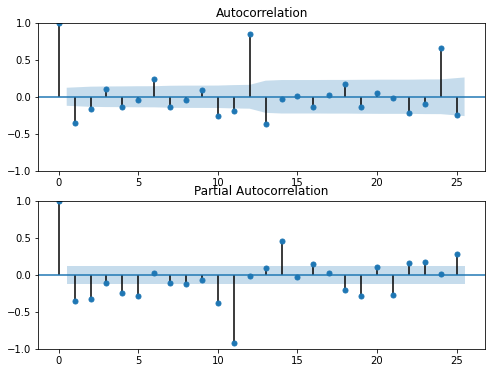

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(logret, ax=ax[0])
plot_pacf(logret, ax=ax[1])
plt.show()

Podemos observar que existen valores altos para las variables 1, 6, 12 y 24. Ya que la variable 6 es a penas significativa, la descartaremos y nos quedaremos con las variables 1, 12, y 24.

Si analizamos el lag entre las variables, podemos identificar una periodicidad de 12.

Para comprobar si nuestra autocorrelación se ha reducido, diferenciaremos nuestra serie y haremos una prueba de Ljung-Box.

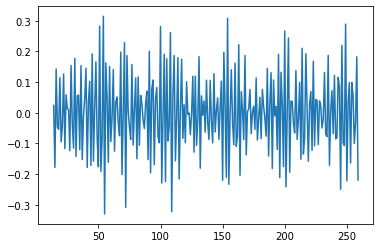

In [17]:
slogret= diff(diff(tslog), k_seasonal_diff=1, seasonal_periods=12)
plt.plot(slogret)
plt.show()

In [ ]:
m = int(np.log(data.shape[0]))
acorr_ljungbox(slogret, lags=[m])

Podemos observar que aún hay un p value menor a 0.05, por lo que diferenciaremos una segunda vez para tratar de reducirlo

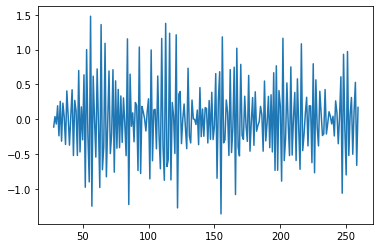

In [18]:
slogret= diff(diff(slogret), k_seasonal_diff=1, seasonal_periods=12)
plt.plot(slogret)
plt.show()

In [19]:
m = int(np.log(data.shape[0]))
acorr_ljungbox(slogret, lags=[m])

,lb_stat,lb_pvalue
5,208.052897,5.372964e-43


El p value se redujo, pero aún es menor a 0.05. Como ya diferenciamos 2 veces, nos quedaremos con este resultado.

Para visualizar nuestra correlación actual, generaremos las gráficas de ACF y PACF de nuevo.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


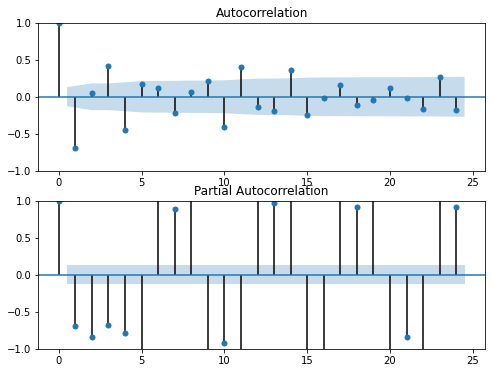

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(slogret, ax=ax[0])
plot_pacf(slogret, ax=ax[1])
plt.show()

Para continuar, usaremos un orden de primer grado para MA y AR. Por lo que tenemos lo siguiente para obtener los posibles valores para nuestro SARIMA:

>$q=0,1$,$Q=0,1$

>$p=0,1$,$P=0,1$

>$d=1$,$D=1$

In [21]:
pp = []
qq = []
PP = []
QQ = []
aic = []
lb = []
sse = []
for p in range(0,2):
    for q in range(0,2):
        for P in range(0,2):
            for Q in range(0,2):
                model=sm.tsa.statespace.SARIMAX(np.log(data_train['sales']),order=(p, 1, q),seasonal_order=(P,1,Q,12))
                res = model.fit()
                pp.append(p)
                qq.append(q)
                PP.append(P)
                QQ.append(Q)
                aic.append(res.aic)
                lb.append(acorr_ljungbox(res.resid, lags=[m]))
                sse.append((res.resid**2).sum())
            
resdf = pd.DataFrame()
resdf['p']=pp
resdf['q']=qq
resdf['PP']=PP
resdf['QQ']=QQ
resdf['AIC']=aic
resdf['lb-p-value']=lb
resdf['sse']=sse

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [23]:
resdf

,p,q,PP,QQ,AIC,lb-p-value,sse
0,0,0,0,0,-581.380470,lb_stat lb_pvalue 5 0.375112 0.995987,88.656807
1,0,0,0,1,-583.628482,lb_stat lb_pvalue 5 0.374621 0.996,88.643501
2,0,0,1,0,-584.710524,lb_stat lb_pvalue 5 0.362594 0.996298,88.627221
3,0,0,1,1,-629.699435,lb_stat lb_pvalue 5 0.332045 0.996997,88.404982
4,0,1,0,0,-773.277881,lb_stat lb_pvalue 5 0.169308 0.999409,87.920466
5,0,1,0,1,-782.195965,lb_stat lb_pvalue 5 0.174099 0.999368,87.905204
6,0,1,1,0,-772.015241,lb_stat lb_pvalue 5 0.167581 0.999424,87.918730
7,0,1,1,1,-822.568710,lb_stat lb_pvalue 5 0.162804 0.999463,87.807437
8,1,0,0,0,-677.945173,lb_stat lb_pvalue 5 0.206261 0.999045,88.208640
9,1,0,0,1,-690.580367,lb_stat lb_pvalue 5 0.204249 0.999067,88.164256


Seleccionaremos la mejor combinación para entrenar nuestro modelo, es decir la que tenga el menor valor de AIC y de SSE. 

Las mejores 3 combinaciones son las siguientes: 15, 7 y 13

A pesar de que la combinación 15 (1,1,1,1)es la que tiene los menores valores de SSE y AIC, también es la más complicada, ya que usa todos los parámetros. Recordando que un modelo más sencillo es mejor, usaremos la combinación 7 (0,1,1,1).







In [28]:
model=sm.tsa.statespace.SARIMAX(np.log(data_train['sales']),order=(0, 1, 1),seasonal_order=(1, 1, 1, 12))
res = model.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  260
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 415.284
Date:                            Thu, 27 Oct 2022   AIC                           -822.569
Time:                                    22:59:27   BIC                           -808.531
Sample:                                         0   HQIC                          -816.917
                                            - 260                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8755      0.033    -26.277      0.000      -0.941      -0.810
ar.S.L12       0.4319      0.093      4.621      0.000       0.249       0.615
ma.S.L12      -0.9878      0.571     -1.731      0.084      -2.107       0.131
sigma2         0.0018      0.001      1.810      0.070      -0.000       0.004
===================================================================================
Ljung-Box (L1) (Q):                  18.52   Jarque-Bera (JB):                 3.31
Prob(Q):                              0.00   Prob(JB):                         0.19
Heteroskedasticity (H):               0.79   Skew:                            -0.26
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Parece que nuestro modelo es bueno, ya que su valor de Prob(JB) es mayor a 0.05. Podríamos intentar otras combinaciones o periodicidades, pero por el momento nos quedaremos con este modelo que aparenta ser preciso.

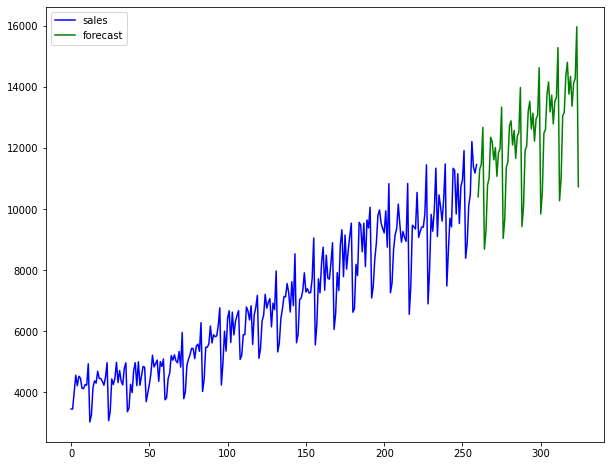

In [29]:
forecast=np.exp(res.predict(start=260,end=324,signal_only=True,dynamic=True))

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(data_train.index,data_train['sales'],label='sales',color='blue')
ax.plot(forecast,label='forecast',color='green')
plt.legend()
plt.show()

Generaremos una gráfica para evaluar el desempeño de nuestro modelo

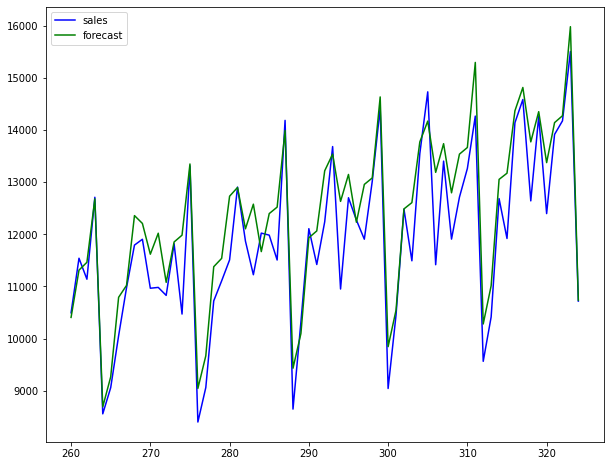

In [30]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(data_test.index,data_test['sales'],label='sales',color='blue')
ax.plot(forecast,label='forecast',color='green')
plt.legend()
plt.show()

Podemos observar que el modelo es bueno y los resultados obtenidos se acercan muvho a los resultados reales. Finalmente obtendremos nuestro MAE 

In [1]:
mae = mean_absolute_error(data_test['sales'], forecast)
print('MAE: ', mae)

NameError: ignored